In [1]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log
from apsg import *
import pandas as pd


microm2m = 1.0E-6
m2microm = 1.0E6

plt.rcParams["figure.figsize"] = (10,10)

In [2]:
flight = 5.0  # sample-sensor distance
area = (0, 1400*microm2m, 0, 2000*microm2m)
shape = (1400,2000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# generates x shallow sourcers
sourcers = 50
D_1 = np.random.normal(30, 2, sourcers)
I_1 = np.random.normal(30, 2, sourcers)
Q_1 = np.random.normal(50000, 1000, sourcers)
R_1 = ( np.random.normal(0.5, 0.2, sourcers) )*microm2m

Xc_1 = np.random.randint(30, 1370, sourcers)*microm2m
Yc_1 = np.random.randint(30, 1970, sourcers)*microm2m
Zc_1 = np.random.randint(1, 10, sourcers)*microm2m


# generates x deep sourcers --> to apply long wavelength noise
sourcers = 10
D_2 = np.random.normal(0, 180, sourcers)
I_2 = np.random.normal(0, 90, sourcers)
Q_2 = np.random.normal(2000, 5, sourcers)
R_2 = ( np.random.normal(10.5, 0.1, sourcers) )*microm2m

Xc_2 = np.random.randint(30, 1370, sourcers)*microm2m
Yc_2 = np.random.randint(30, 1970, sourcers)*microm2m
Zc_2 = np.random.randint(500, 550, sourcers)*microm2m

# concat. sources
D = np.concatenate((D_1, D_2))
I = np.concatenate((I_1, I_2))
Q = np.concatenate((Q_1, Q_2))
R = np.concatenate((R_1, R_2))

Xc = np.concatenate((Xc_1, Xc_2))
Yc = np.concatenate((Yc_1, Yc_2))
Zc = np.concatenate((Zc_1, Zc_2))


m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)

In [3]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
d = noise(d, error=150.0e-9, method='fixed')

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

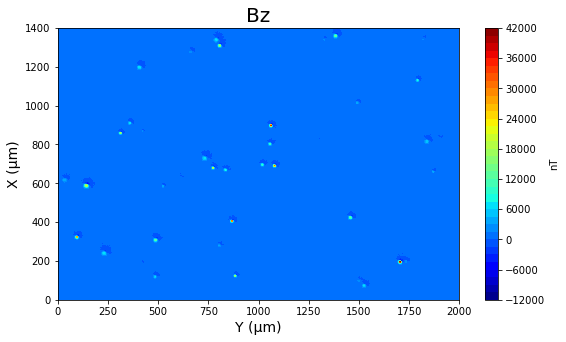

In [4]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

In [5]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


Text(0, 0.5, 'X (µm)')

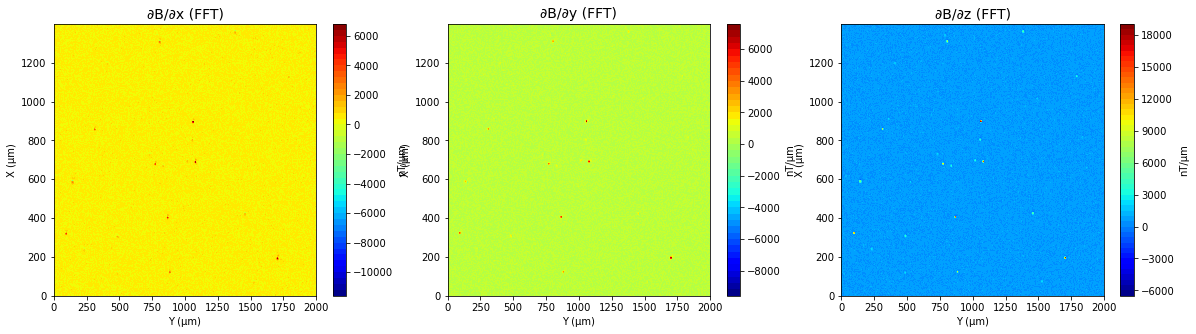

In [6]:
# plot FFT derivatives
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], ddx[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot[::2], y_plot[::2], ddy[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot[::2], y_plot[::2], ddz[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'X (µm)')

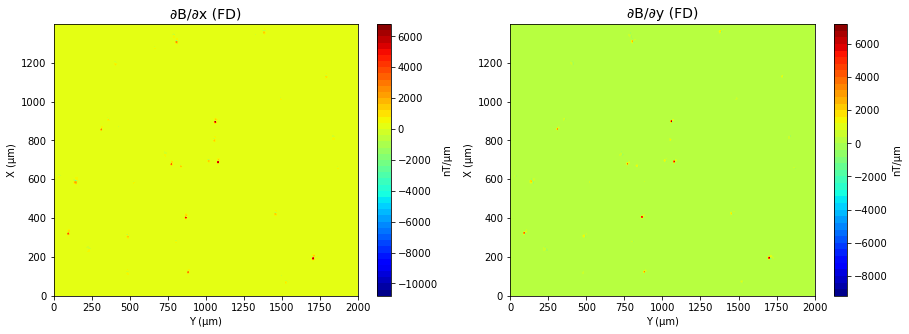

In [7]:
# plot FD derivatives
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], d_X[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], d_Y[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [8]:
# Calculating the horizontal gradient (GH) using FFT e FD

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

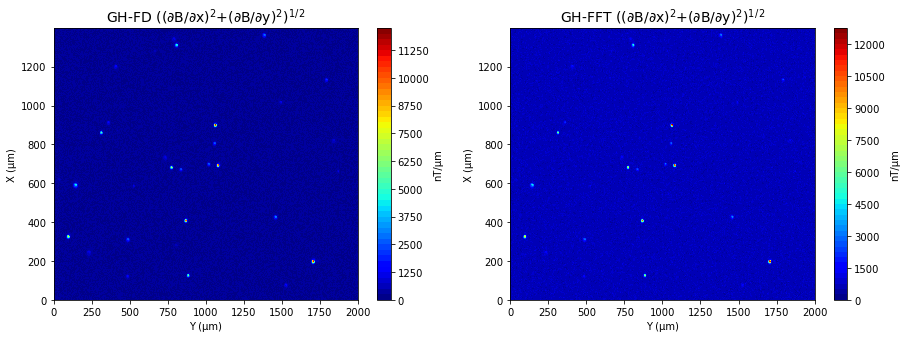

In [9]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FD[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FFT[::2]*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

In [10]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

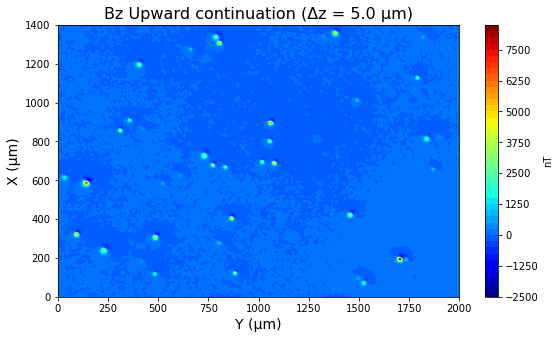

In [11]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=16)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



In [12]:
# New derivatives by FFT
ddy = y_derivative_fft(upward, wy)
ddx = x_derivative_fft(upward, wx)
ddz = z_derivative_fft(upward, wz)


Text(0, 0.5, 'X (µm)')

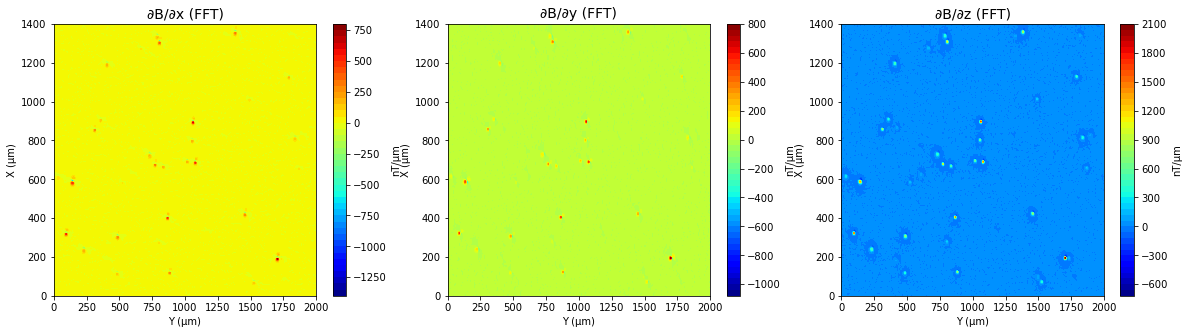

In [13]:
# Plot derivatives by FFT (after upward continuation)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, ddx*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FFT)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot  = ax2.contourf(x_plot, y_plot, ddy*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FFT)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot  = ax3.contourf(x_plot, y_plot, ddz*10**3, levels=50, cmap='jet')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FFT)', fontsize=14)
ax3.set_xlabel('Y (µm)', fontsize=10)
ax3.set_ylabel('X (µm)', fontsize=10)


In [14]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

Text(0, 0.5, 'X (µm)')

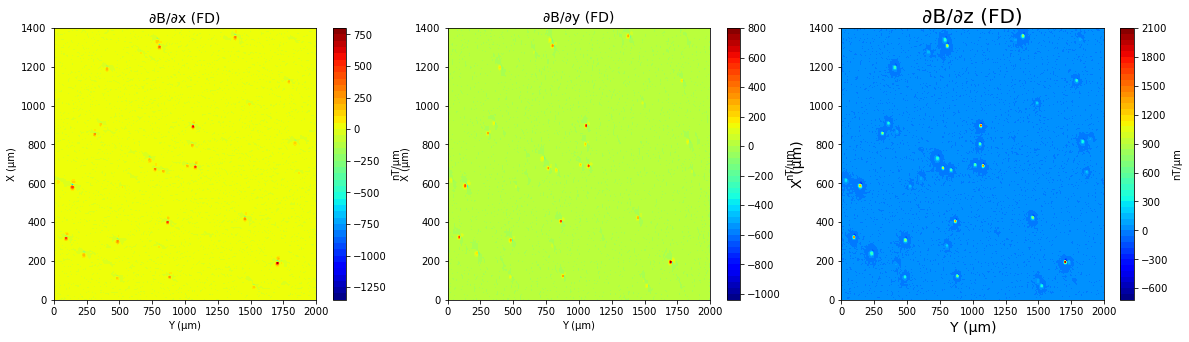

In [15]:
# Plot derivatives by FD (after upward continuation)
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

ax1_plot  = ax1.contourf(x_plot, y_plot, d_X*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('∂B/∂x (FD)', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

ax2_plot = ax2.contourf(x_plot, y_plot, d_Y*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('∂B/∂y (FD)', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, d_Z*10**3, levels=50, cmap='jet')
plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
ax3.set_title('∂B/∂z (FD)', fontsize=20)
ax3.set_xlabel('Y (µm)', fontsize=14)
ax3.set_ylabel('X (µm)', fontsize=14)

In [16]:
# total gradient data
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)
Total_Grad_FFT = Total_Grad(ddy, ddx, ddz)

Text(0, 0.5, 'X (µm)')

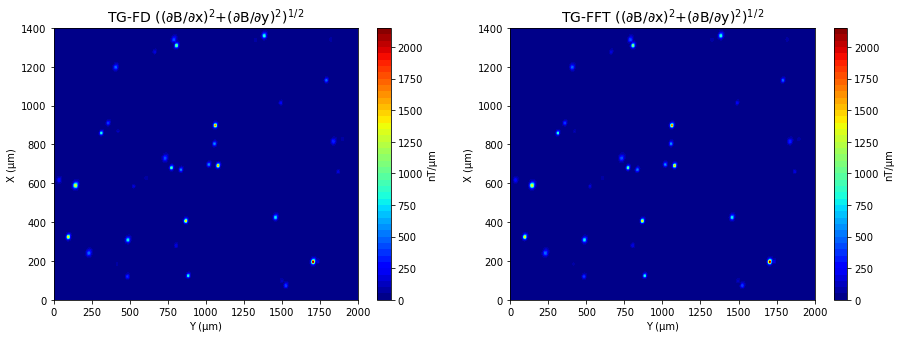

In [17]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# plot FD total gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('TG-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax2.set_xlabel('Y (µm)', fontsize=10)
ax2.set_ylabel('X (µm)', fontsize=10)

# Euler solver

Text(0, 0.5, 'Count')

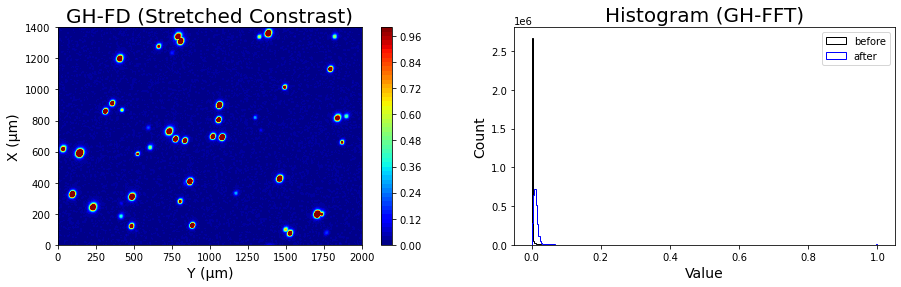

In [18]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (0.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='jet')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


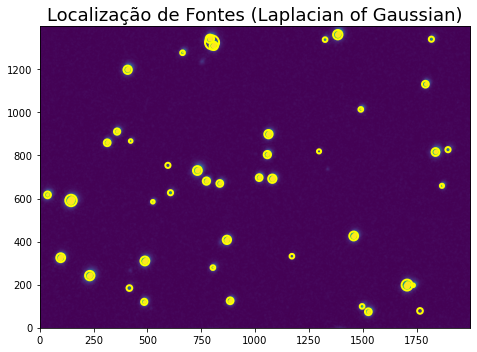

(43, 4)


()

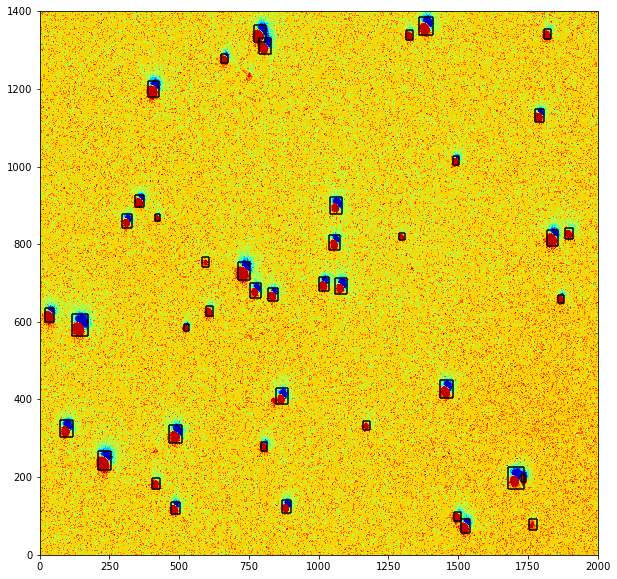

In [19]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.07, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.1)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')

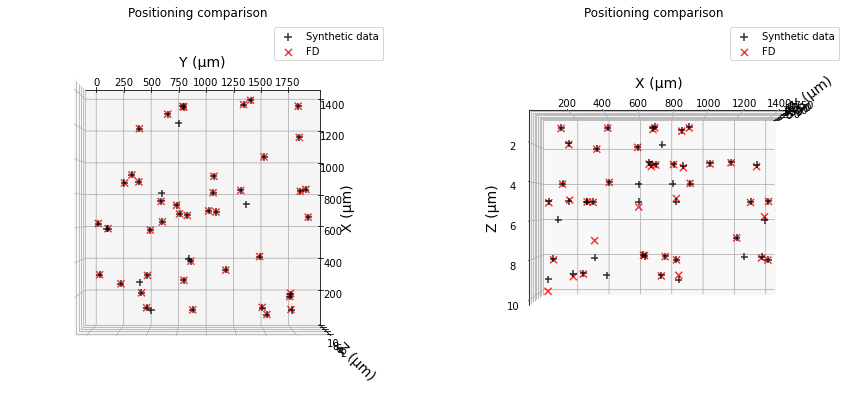

In [20]:
from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc_1*m2microm, Xc_1*m2microm, Zc_1*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()

# Magnetic inversion using lest square method

Mean direction: 30.13679845534037 / 29.352748608477807


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,28.1692,0.0524,28.0991,0.0361,1.815795e-13,1.380281e-16,591.352739,144.828358,5.288835
1,30.0924,0.0609,33.1083,0.0411,5.703500e-14,4.682154e-17,900.017937,1062.982590,1.058725
2,30.2575,0.0649,29.4539,0.0446,6.915937e-14,6.399030e-17,326.002043,96.998506,2.025298
3,31.7679,0.0649,30.6317,0.0443,5.197803e-14,4.722465e-17,693.029818,1080.978565,1.050590
4,29.3051,0.0640,26.7152,0.0443,5.025521e-14,4.755687e-17,408.112257,869.035956,1.022691


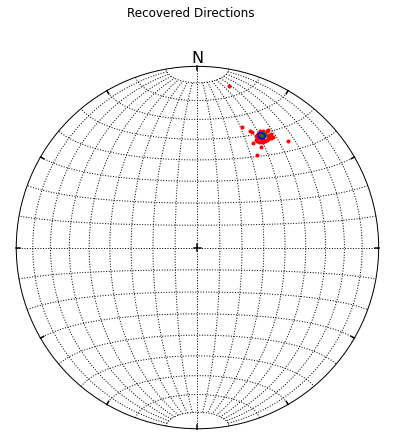

In [21]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
#d = np.squeeze(d)

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_least, my_FD_least, mz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True, show_mean=True, show_alpha95=True)

#calculate momentum
momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


#Inversion uncertainties
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, mx_FD_least, my_FD_least, mz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)


Mean direction: 30.243220205906933 / 29.51038556026929


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,29.3647,0.1162,28.6081,0.0800,1.815928e-13,3.041440e-16,591.352739,144.828358,5.288835
1,30.0970,0.2042,33.0688,0.1379,5.661872e-14,1.560184e-16,900.017937,1062.982590,1.058725
2,30.2211,0.1913,29.4873,0.1312,6.881497e-14,1.874631e-16,326.002043,96.998506,2.025298
3,31.9555,0.2181,30.6447,0.1489,5.157808e-14,1.575259e-16,693.029818,1080.978565,1.050590
4,29.0868,0.2156,26.8330,0.1493,5.002834e-14,1.592237e-16,408.112257,869.035956,1.022691


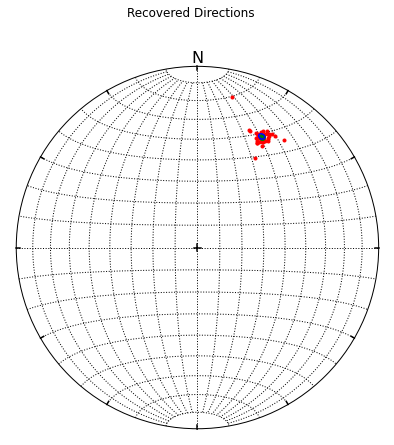

In [22]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

mx_FD_up_least, my_FD_up_least, mz_FD_up_least, M_FD_up_least, direct_model_FD_up_least = least_square_solver(X, Y, Z+delta_z, Xc_FD, Yc_FD, Zc_FD, upward)
D_FD_up_least, I_FD_up_least = directions(mx_FD_up_least, my_FD_up_least, mz_FD_up_least, plot=True, show_mean=True, show_alpha95=True)

#calculate momentum
momentum_FD_up_least = (np.sqrt(mx_FD_up_least**2 + my_FD_up_least**2 + mz_FD_up_least**2))


#Inversion uncertainties
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_up_FD_least, sigma_I_FD_up_least, sigma_m_FD_up_least = uncertainties(sigma_noise, M_FD_up_least, mx_FD_up_least, my_FD_up_least, mz_FD_up_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_up_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_up_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_up_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_up_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_up_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_up_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Magnetic inversion using robust method

iteration:  1
iteration:  2
Mean direction: 30.140527662091454 / 29.34439070681014


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,28.2400,0.0525,28.0913,0.0362,1.811540e-13,1.380325e-16,591.352739,144.828358,5.288835
1,30.0885,0.0609,33.1082,0.0411,5.703496e-14,4.682156e-17,900.017937,1062.982590,1.058725
2,30.2545,0.0649,29.4505,0.0446,6.915192e-14,6.399124e-17,326.002043,96.998506,2.025298
3,31.7826,0.0648,30.6151,0.0443,5.197438e-14,4.722809e-17,693.029818,1080.978565,1.050590
4,29.3424,0.0641,26.7094,0.0444,5.019272e-14,4.755794e-17,408.112257,869.035956,1.022691


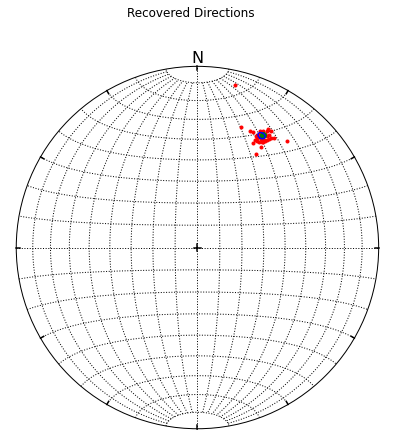

In [23]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation

mx_FD_robust, my_FD_robust, mz_FD_robust, M_FD_robust, direct_model_FD_robust = robust_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_robust, I_FD_robust = directions(mx_FD_robust, my_FD_robust, mz_FD_robust, plot=True, show_mean=True, show_alpha95=True)

#calculate momentum
momentum_FD_robust = (np.sqrt(mx_FD_robust**2 + my_FD_robust**2 + mz_FD_robust**2))


#Inversion uncertainties
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_FD_robust, sigma_I_FD_robust, sigma_m_FD_robust = uncertainties(sigma_noise, M_FD_robust, mx_FD_robust, my_FD_robust, mz_FD_robust)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_robust, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_robust, decimals=4)),
                        'Inc (°)': (np.round(I_FD_robust, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_robust, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_robust),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_robust),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)


iteration:  1
iteration:  2
Mean direction: 30.283655394887454 / 29.49412436091413


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,29.4532,0.1164,28.5508,0.0802,1.810823e-13,3.042162e-16,591.352739,144.828358,5.288835
1,30.0905,0.2042,33.0873,0.1378,5.664330e-14,1.560050e-16,900.017937,1062.982590,1.058725
2,30.2103,0.1913,29.4865,0.1312,6.879844e-14,1.874637e-16,326.002043,96.998506,2.025298
3,31.9584,0.2182,30.6893,0.1489,5.157367e-14,1.574950e-16,693.029818,1080.978565,1.050590
4,29.1272,0.2157,26.8656,0.1493,5.001666e-14,1.592034e-16,408.112257,869.035956,1.022691


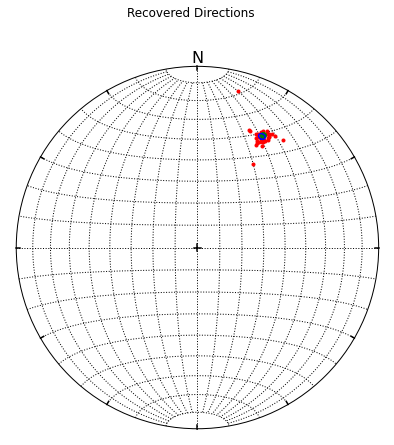

In [24]:
mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust, M_FD_up_robust, direct_model_FD_up_robust = robust_solver(X, Y, Z+delta_z, Xc_FD, Yc_FD, Zc_FD, upward)
D_FD_up_robust, I_FD_up_robust = directions(mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust, plot=True, show_mean=True, show_alpha95=True)

#calculate momentum
momentum_FD_up_robust = (np.sqrt(mx_FD_up_robust**2 + my_FD_up_robust**2 + mz_FD_up_robust**2))


#Inversion uncertainties
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_up_FD_robust, sigma_I_FD_up_robust, sigma_m_FD_up_robust = uncertainties(sigma_noise, M_FD_up_robust, mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_up_robust, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_up_FD_robust, decimals=4)),
                        'Inc (°)': (np.round(I_FD_up_robust, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_up_robust, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_up_robust),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_up_robust),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Momentum Errorbars

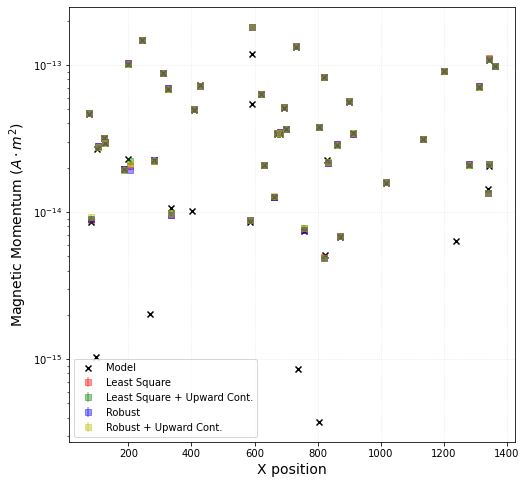

In [25]:
sources = np.copy(Xc_FD*m2microm)

real=(np.array(Q_1)*4/3*np.pi*np.array(R_1)**3)

plt.figure(figsize=(8,8))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')
plt.errorbar(sources, momentum_FD_up_least, sigma_m_FD_up_least, fmt='s', alpha=0.4, color='g', label='Least Square + Upward Cont.')
plt.errorbar(sources, momentum_FD_robust, sigma_m_FD_robust, fmt='s', alpha=0.4, color='b', label='Robust')
plt.errorbar(sources, momentum_FD_up_robust, sigma_m_FD_up_robust, fmt='s', alpha=0.4, color='y', label='Robust + Upward Cont.' )

plt.scatter(np.array(Xc_1*m2microm), real, marker='x', color='k', label='Model')

plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')
